In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host='localhost',
                           username='root',
                           password='naveenroyal@777',
                           database='Project1')
cur=db.cursor()

# List all unique cities where customers are located.

In [5]:
query="""select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['cities'])
df.head()

,cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [6]:
query="""select count(order_id) as numbers_of_orders from orders
where year(order_purchase_timestamp)='2017'"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Total_nof_orders'])
df.head()

,Total_nof_orders
0,45101


# Find the total sales per category.

In [7]:
query="""select product_category,round(sum(j.payment_value),2) as total_sales from products as p
join order_items as o
on o.product_id=p.product_id
join payments as j
on j.order_id=o.order_id
group by product_category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['product_name','total_sales'])
df.head()

,product_name,total_sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


# Calculate the percentage of orders that were paid in installments.

In [5]:
query="""select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 as percentage from payments"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['percentage'])
df

,percentage
0,99.9981


# Count the number of customers from each state.

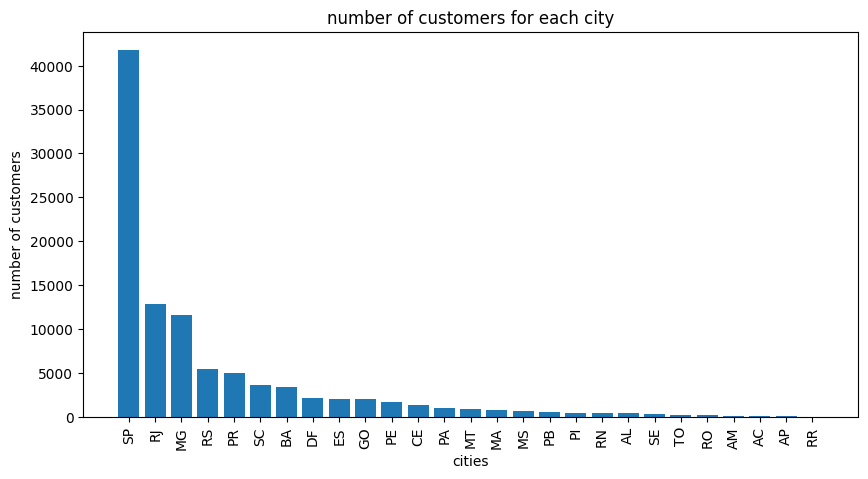

In [9]:
query="""select customer_state,count(*) as total_number_of_customers from customers
group by customer_state
order by total_number_of_customers desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['customer_city','total_number_of_customers'])
df.head()
plt.figure(figsize=(10,5))
plt.bar(df['customer_city'],df['total_number_of_customers'])
plt.xticks(rotation=90)
plt.xlabel('cities')
plt.ylabel('number of customers')
plt.title('number of customers for each city')
plt.show()

# Calculate the number of orders per month in 2018.

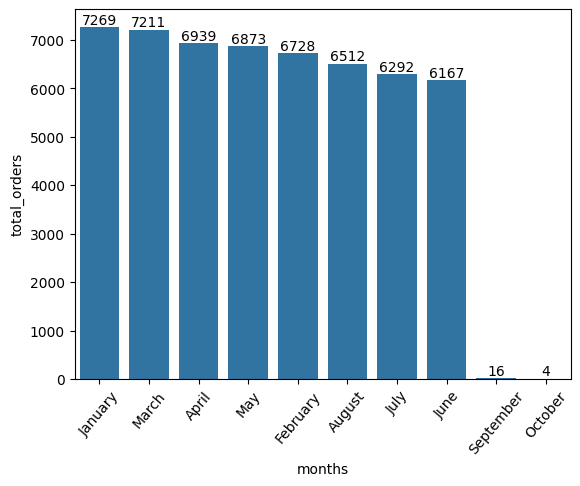

In [10]:
query="""select MONTHNAME(order_purchase_timestamp) as months,count(order_id) as total_orders from orders
where year(order_purchase_timestamp)='2018'
group by MONTHNAME(order_purchase_timestamp)
order by count(order_id) desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['months','total_orders'])
df.head()
a=sns.barplot(x=df['months'],y=df['total_orders'])
a.bar_label(a.containers[0])
plt.xticks(rotation=50)
plt.show()


# Find the average number of products per order, grouped by customer city.

  customer_city  avg_order
0       January       7269
1         March       7211
2         April       6939
3           May       6873
4      February       6728
5        August       6512
6          July       6292
7          June       6167
8     September         16
9       October          4


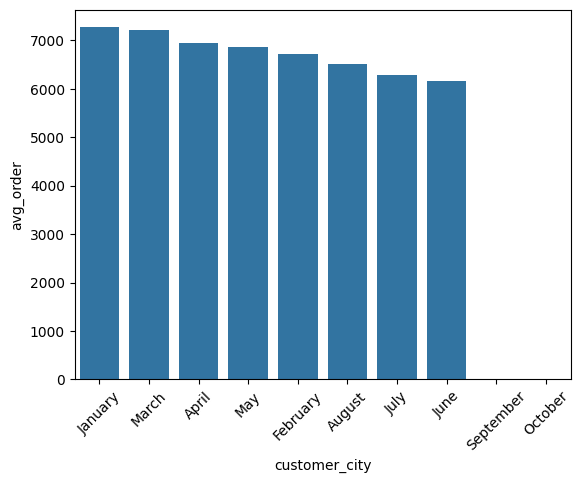

In [11]:
query="""

with  a as (select orders.customer_id as cust_id,orders.order_id,count(order_items.order_item_id) as count_of_orders from orders 
            join order_items 
             on order_items.order_id=orders.order_id
              group by orders.order_id,orders.customer_id )

select customers.customer_city,round(avg(a.count_of_orders),2) as avg_orders from customers
join a
on a.cust_id=customers.customer_id
group by customers.customer_city
order by avg_orders desc;
"""
cur.execute(query)
cur.fetchall()
df=pd.DataFrame(data,columns=['customer_city','avg_order'])
df_top10 = df.head(10)
sns.barplot(x=df_top10['customer_city'],y=df_top10['avg_order'])
plt.xticks(rotation=45)
plt.show()

# Calculate the percentage of total revenue contributed by each product category.

In [45]:
query7="""select product_category,round(sum(j.payment_value)/(select sum(payment_value) from payments)*100,2) as sales_percentage from products as p
join order_items as o
on o.product_id=p.product_id
join payments as j
on j.order_id=o.order_id
group by product_category
order by sales_percentage desc;"""
cur.execute(query7)
data7=cur.fetchall()
df7=pd.DataFrame(data7,columns=['product','percentage_distribution'])
df7.head()

,product,percentage_distribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
query="""select products.product_category,round(avg(order_items.price),2),count(order_items.product_id) as num_of_products_purchased from products
join order_items
on products.product_id=order_items.product_id
group by products.product_category
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['products','cost','num_of_items'])
df.head()
price=df['cost'].values
purchase_count=df['num_of_items'].values
corr_diff=np.corrcoef(price,purchase_count)[0][1]
print("correlation between price and number of times a product has been purchased is",corr_diff)

correlation between price and number of times a product has been purchased is -0.10631514167157569


# Calculate the total revenue generated by each seller, and rank them by revenue.

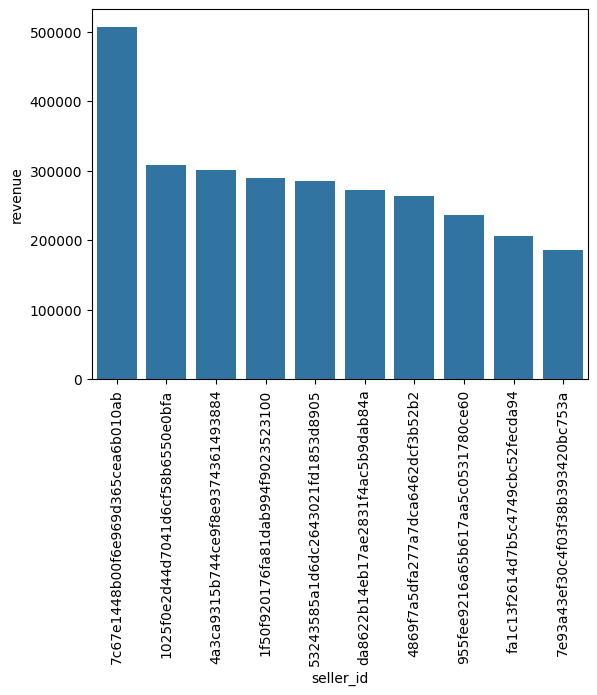

In [13]:
query="""with a as(select order_items.seller_id,round(sum(payment_value),2) as revenue from payments
join order_items
on order_items.order_id=payments.order_id
group by order_items.seller_id)
select *, dense_rank() over(order by revenue desc) as rnk from a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['seller_id','revenue','rank'])
dg=df.head(10)
sns.barplot(x=dg['seller_id'],y=dg['revenue'])
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [16]:
query="""
    select cust_id,pur_time,avg(payment) over(partition by cust_id order by pur_time
    rows between 2 preceding and current row) from 
    (SELECT 
        orders.customer_id AS cust_id,
        orders.order_purchase_timestamp AS pur_time,
        payments.payment_value AS payment
    FROM orders
    JOIN payments ON payments.order_id = orders.order_id) as x"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['customer_id','purchase_time','mov_avg'])
df.head()

,customer_id,purchase_time,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002


# Calculate the cumulative sales per month for each year.

In [8]:
query="""select years,months,paymentss,sum(paymentss) over(order by years,months) as cum_sales from 
(select year(order_purchase_timestamp) as years,month(order_purchase_timestamp) as months,sum(payments.payment_value) as paymentss
from orders
join payments
on payments.order_id=orders.order_id
group by years,months
order by years,months) as x"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['year','month','payment','cum_sales'])
df.tail()

,year,month,payment,cum_sales
20,2018,6,1.023881e+06,1.391488e+07
21,2018,7,1.066541e+06,1.498142e+07
22,2018,8,1.022425e+06,1.600384e+07
23,2018,9,4.439540e+03,1.600828e+07
24,2018,10,5.896700e+02,1.600887e+07


# Calculate the year-over-year growth rate of total sales.

In [14]:
query="""with a as(select year(orders.order_purchase_timestamp) as years,round(sum(p.payment_value),2) as total_sales from orders
join payments as p
on p.order_id=orders.order_id
group by years)
select years,((total_sales-lag(total_sales) over(order by years))/lag(total_sales) over(order by years))*100 as year from a;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['year','yoy % growth'])
df.head()

,year,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year.

In [4]:
query="""select yrs,customer,purchas,rnk
from 
(select orders.customer_id as customer,year(orders.order_purchase_timestamp) as yrs,
sum(payments.payment_value) as purchas,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as rnk
from orders
join payments
on payments.order_id=orders.order_id
group by customer,yrs) as x
where rnk<=3"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['year','customer','payment','rank'])
df

,year,customer,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3
